In [2]:
pip install wandb

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import wandb
from tensorflow.keras.models import model_from_json
import cv2

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, UpSampling2D
import random
import glob
import wandb
from wandb.keras import WandbCallback
import subprocess
import os
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow, figure
import matplotlib.pyplot as plt


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  1
2.2.0


In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%cd /content/drive/My Drive/sat_tif

In [6]:
#initialize wandb and download dataset

hyperparams = {"num_epochs": 10, 
          "batch_size": 1,
          "height": 984,
          "width": 1074}

wandb.init(config=hyperparams)
config = wandb.config
##########
#val_dir='/content/drive/My Drive/catz/test1'
#train_dir='/content/drive/My Drive/catz/train1'
val_dir='vis_isro_new'
train_dir='tir_isro_new'
############


# val_dir = 'catz/test'
# train_dir = 'catz/train'

# # automatically get the data if it doesn't exist
# if not os.path.exists("catz"):
#     print("Downloading catz dataset...")
#     subprocess.check_output(
#         "curl https://storage.googleapis.com/wandb/catz.tar.gz | tar xz", shell=True)

In [36]:
val_dir='/content/drive/My Drive/catz/test1'
train_dir='/content/drive/My Drive/catz/train1'

In [39]:
!unzip tir_isro_new.zip -d train_dir

unzip:  cannot find or open tir_isro_new.zip, tir_isro_new.zip.zip or tir_isro_new.zip.ZIP.


In [53]:
!ls /content/drive/My Drive/catz/

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/catz/': No such file or directory


In [44]:
!ls

drive  sample_data  wandb


In [7]:
# generator to loop over train and test images

def my_generator3(batch_size, img_dir):
    """A generator that returns 5 images plus a result image"""
    cat_dirs = glob.glob(img_dir + "/*")
    #print(len(cat_dirs))
    counter = 0
    while True:
        input_images = np.zeros(
            (batch_size,config.height, config.width,5*1))
        output_images = np.zeros((batch_size,config.height, config.width,1))
        random.shuffle(cat_dirs)
        if (counter+batch_size >= len(cat_dirs)):
            counter = 0
        for i in range(batch_size):
            input_imgs = glob.glob(cat_dirs[counter + i] + "/[0-5]*")
            imgs = [Image.open(img) for img in sorted(input_imgs)]
            
            
            imgs1=[np.reshape(im, (984, 1074, 1)) for im in imgs]
            # input_images[i] = np.concatenate(imgs, axis=2)
            # for img in sorted(input_imgs):
            #     #p=np.array(imgs[i])
            #     im=Image.open(img)
            #     im=im.resize((96,96),Image.ANTIALIAS)
            #     im = np.array(im)
            #     img = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
            #     input_images[i]=np.concatenate((input_images[i],im),axis=1)     
            input_images[i]=np.concatenate((imgs1),axis=2)
            output_images[i] = np.reshape(Image.open(cat_dirs[counter + i] + "/result.tif"),(984, 1074, 1))
            
            #input_images[i] /= 255.
            #output_images[i] /= 255.
        yield (input_images, output_images)
        counter =counter+batch_size
        
steps_per_epoch = len(glob.glob(train_dir + "/*")) // config.batch_size
validation_steps = len(glob.glob(val_dir + "/*")) // config.batch_size

In [8]:
#callback to log the images

class ImageCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        validation_X, validation_y = next(
            my_generator3(1, val_dir))
        output = self.model.predict(validation_X)
        """wandb.log({
            "input": [wandb.Image(np.concatenate(np.split(c, 5, axis=2), axis=1)) for c in validation_X],
            "output": [wandb.Image(np.concatenate([validation_y[i], o], axis=1)) for i, o in enumerate(output)]
        }, commit=False)"""

In [9]:
# Test the generator
gen = my_generator3(1, train_dir)
videos, next_frame = next(gen)
print(videos[0].shape)
next_frame[0].shape

(984, 1074, 5)


(984, 1074, 1)

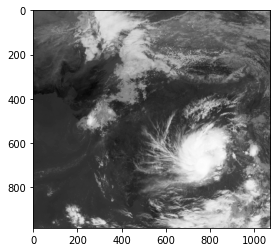

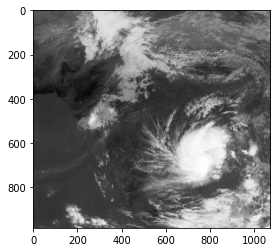

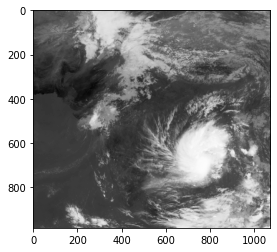

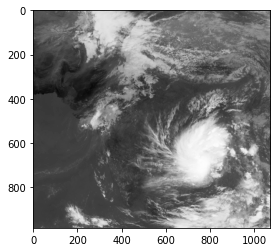

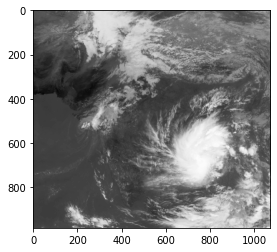

In [10]:
figure()
imshow(videos[0][:,:,0],cmap='gray')
figure()
imshow(videos[0][:,:,1],cmap='gray')
figure()
imshow(videos[0][:,:,2],cmap='gray')
figure()
imshow(videos[0][:,:,3],cmap='gray')
figure()
imshow(videos[0][:,:,4],cmap='gray')
#

In [ ]:
# Function for measuring how similar two images are
def perceptual_distance(y_true, y_pred):
    y_true *= 255.
    y_pred *= 255.
    rmean = (y_true[:, :, :, 0] + y_pred[:, :, :, 0]) / 2
    r = y_true[:, :, :, 0] - y_pred[:, :, :, 0]
    g = y_true[:, :, :, 1] - y_pred[:, :, :, 1]
    b = y_true[:, :, :, 2] - y_pred[:, :, :, 2]
    #g=b=r
    return K.mean(K.sqrt((((512+rmean)*r*r)/256) + 4*g*g + (((767-rmean)*b*b)/256)))

# model1


In [ ]:
# wandb.init(config=hyperparams)
# config = wandb.config
#tf.keras.metrics.RootMeanSquaredError()
model = Sequential()
model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit_generator(my_generator3(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator3(config.batch_size, val_dir))



Epoch 1/10
1/1 [==============================] - 1s 875ms/step - loss: 4.2530 - root_mean_squared_error: 2.0623 - val_loss: 4.7855 - val_root_mean_squared_error: 2.1876
Epoch 2/10
1/1 [==============================] - 1s 955ms/step - loss: 4.5641 - root_mean_squared_error: 2.1364 - val_loss: 4.8131 - val_root_mean_squared_error: 2.1939
Epoch 3/10
1/1 [==============================] - 1s 965ms/step - loss: 4.3256 - root_mean_squared_error: 2.0798 - val_loss: 4.2516 - val_root_mean_squared_error: 2.0619
Epoch 4/10
1/1 [==============================] - 1s 968ms/step - loss: 3.6440 - root_mean_squared_error: 1.9089 - val_loss: 4.3320 - val_root_mean_squared_error: 2.0813
Epoch 5/10
1/1 [==============================] - 1s 959ms/step - loss: 3.6900 - root_mean_squared_error: 1.9209 - val_loss: 3.9012 - val_root_mean_squared_error: 1.9751
Epoch 6/10
1/1 [==============================] - 1s 953ms/step - loss: 4.1205 - root_mean_squared_error: 2.0299 - val_loss: 3.9274 - val_root_mean_sq

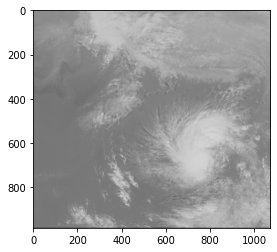

In [ ]:
result=model.predict(videos)
# figure()
#result=Image.open(result)
#result=np.asarray(result[0]).astype('uint8')
imshow(result[0][:,:,0],cmap='gray')
#imshow(next_frame[0][:,:,1],cmap='gray')


# model3 Conv2DLSTM with Gaussian Noise

In [ ]:
#model6

In [ ]:
# Conv2DLSTM with Gaussian Noise

from tensorflow.keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, ConvLSTM2D
from tensorflow.keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 1))
reshaped = Reshape((config.height,config.width,5,1))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(config.width,config.height,5,1), output_shape=(config.width,config.height,1))(noise)
permuted_2 = Permute((4,1,2,3))(noise)

conv_lstm_output_1 = ConvLSTM2D(32, (3,3), padding='same')(permuted_2)
conv_output = Conv2D(1, (3,3), padding="same")(conv_lstm_output_1)
combined = add([last_layer, conv_output])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.fit_generator(my_generator3(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs*5, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator3(config.batch_size, val_dir))

Epoch 1/50
44/44 [==============================] - 327s 7s/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 1.1415e-06 - val_root_mean_squared_error: 0.0011
Epoch 2/50
44/44 [==============================] - 291s 7s/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 5.7677e-05 - val_root_mean_squared_error: 0.0076
Epoch 3/50
44/44 [==============================] - 237s 5s/step - loss: 7.2747e-05 - root_mean_squared_error: 0.0085 - val_loss: 5.5590e-06 - val_root_mean_squared_error: 0.0024
Epoch 4/50
44/44 [==============================] - 205s 5s/step - loss: 2.9596e-05 - root_mean_squared_error: 0.0054 - val_loss: 1.2630e-05 - val_root_mean_squared_error: 0.0036
Epoch 5/50
44/44 [==============================] - 142s 3s/step - loss: 2.0826e-05 - root_mean_squared_error: 0.0046 - val_loss: 3.6772e-06 - val_root_mean_squared_error: 0.0019
Epoch 6/50
44/44 [==============================] - 168s 4s/step - loss: 1.8070e-05 - root_mean_squared_error: 0.

In [11]:
# Conv2DLSTM with Gaussian Noise

from tensorflow.keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, ConvLSTM2D
from tensorflow.keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 1))
reshaped = Reshape((config.height,config.width,5,1))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(config.width,config.height,5,1), output_shape=(config.width,config.height,1))(noise)
permuted_2 = Permute((4,1,2,3))(noise)

conv_lstm_output_1 = ConvLSTM2D(32, (3,3), padding='same')(permuted_2)
conv_output = Conv2D(1, (3,3), padding="same")(conv_lstm_output_1)
combined = add([last_layer, conv_output])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer="adadelta", loss='binary_crossentropy', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.fit_generator(my_generator3(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs*5, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator3(config.batch_size, val_dir))

Epoch 1/50
10/10 [==============================] - 15s 1s/step - loss: -24.7516 - root_mean_squared_error: 0.2113 - val_loss: 0.4452 - val_root_mean_squared_error: 0.1354
Epoch 2/50
10/10 [==============================] - 14s 1s/step - loss: -23.9122 - root_mean_squared_error: 0.2178 - val_loss: 0.5828 - val_root_mean_squared_error: 0.1432
Epoch 3/50
10/10 [==============================] - 13s 1s/step - loss: -23.7248 - root_mean_squared_error: 0.2226 - val_loss: 0.4506 - val_root_mean_squared_error: 0.1573
Epoch 4/50
10/10 [==============================] - 13s 1s/step - loss: -23.8054 - root_mean_squared_error: 0.2155 - val_loss: 0.4368 - val_root_mean_squared_error: 0.1369
Epoch 5/50
10/10 [==============================] - 12s 1s/step - loss: -24.4478 - root_mean_squared_error: 0.2115 - val_loss: 0.4763 - val_root_mean_squared_error: 0.1397
Epoch 6/50
10/10 [==============================] - 12s 1s/step - loss: -23.9332 - root_mean_squared_error: 0.2137 - val_loss: 0.3748 - val_

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 984, 1074, 5 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 984, 1074, 5, 0           input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 984, 1074, 1, 0           reshape[0][0]                    
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 984, 1074, 1, 0           permute[0][0]                    
______________________________________________________________________________________________

In [17]:
result=model.predict(videos)

**ACTUAL FRAME**

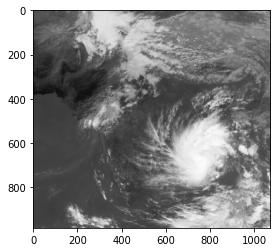

In [18]:
imshow(next_frame[0][:,:,0],cmap='gray')

**PREDICTED FRAME**

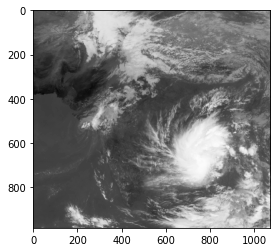

In [19]:
imshow(result[0][:,:,0],cmap='gray')

**Model 4 by adding 6 conv LSTM layer**

In [ ]:
# Conv2DLSTM with Gaussian Noise

from tensorflow.keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, concatenate
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, TimeDistributed, Add
from tensorflow.keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

c=4

inp = Input((config.height, config.width, 5 * 1))
reshaped = Reshape((config.height, config.width,5,1))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(config.height, config.width,1,5), output_shape=(config.height, config.width,1))(noise)
x = Permute((4,1,2,3))(noise)
x =(ConvLSTM2D(filters=c, kernel_size=(3,3),padding='same',name='conv_lstm1', return_sequences=True))(x)

c1=(BatchNormalization())(x)
x = Dropout(0.2)(x)
#x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c1)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm3',return_sequences=True))(x)
c2=(BatchNormalization())(x)
x = Dropout(0.2)(x)

#x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c2)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm4',return_sequences=True))(x)

#x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm5',return_sequences=True))(x)
x =(BatchNormalization())(x)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm6',return_sequences=True))(x)
x =(BatchNormalization())(x)
x = Add()([c2, x])
x = Dropout(0.2)(x)

#x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=c,kernel_size=(3,3),padding='same',name='conv_lstm7',return_sequences=False))(x)
x =(BatchNormalization())(x)
combined = concatenate([last_layer, x])
combined = Conv2D(1, (1,1))(combined)
model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.fit_generator(my_generator3(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator3(config.batch_size, val_dir))